<a href="https://colab.research.google.com/github/UV1999/Data_Lit---Siraj_Raval/blob/master/kaggle_lanl_earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Dependencies

In [1]:
!pip install kaggle
!pip install numpy==1.15.0
!pip install catboost

Importing Libraries

In [0]:
import pandas as pd   #datapreprocessing
import numpy as np    #math operations
from catboost import CatBoostRegressor, Pool   #machine learning
from sklearn.preprocessing import StandardScaler   #data scaling
from sklearn.model_selection import GridSearchCV   #hyperparameter optimization
from sklearn.svm import NuSVR, SVR   #support vector machine model
from sklearn.kernel_ridge import KernelRidge   #kernel ridge model
import matplotlib.pyplot as plt   #data visualization

Import Dataset from Kaggle

In [3]:
from google.colab import files    #Colab's file access feature
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json   #Then move kaggle.json into the folder where the API expects to find it

Saving kaggle.json to kaggle.json


Listing Kaggle Competitions

In [8]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2867           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11179           False  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4260           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         40           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2809           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

Downloading LANL Earthquake Data

In [11]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 15.1MB/s]
 98% 238M/242M [00:01<00:00, 150MB/s]
100% 242M/242M [00:01<00:00, 128MB/s]
100% 2.02G/2.03G [00:36<00:00, 25.3MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.7MB/s]


Locating the Dataset and Unzipping

In [15]:
!ls     #locating the files
!unzip train.csv.zip     #unzipping the train dataset
!ls


sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


Explanatory Data Analysis

In [26]:
#extracting training data to a dataframe
train = pd.read_csv('train.csv', nrows = 6000000, dtype = {'acoustic_data' : np.int16, 'time_to_failure' : np.float64})
#printing first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


Visualizing 2% of sample data

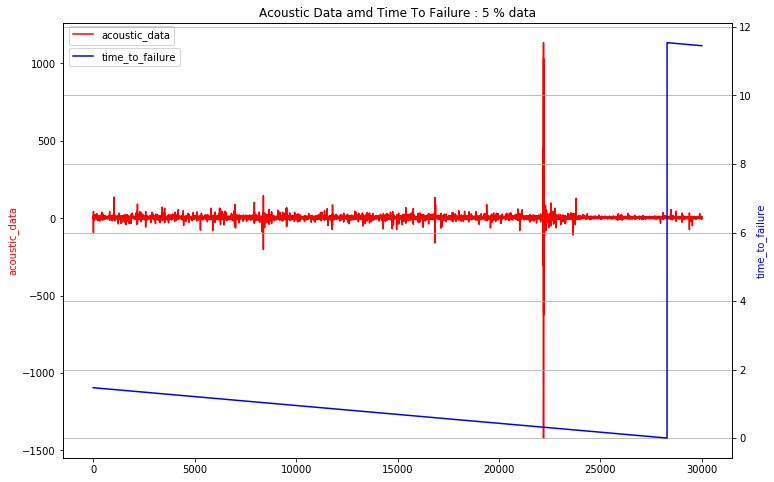

In [29]:
train_ad = train['acoustic_data'].values[::200]
train_ttf = train['time_to_failure'].values[::200]

#function for plotting based on both the features
def plot (train_ad,train_ttf, title = "Acoustic Data amd Time To Failure : 5 % data") :
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad,color='r')
  ax1.set_ylabel('acoustic_data',color='r')
  plt.legend(['acoustic_data'],loc=(0.01,0.95))
  ax2=ax1.twinx()
  plt.plot(train_ttf, color='b')
  ax2.set_ylabel('time_to_failure', color='b')
  plt.legend(['time_to_failure'], loc=(0.01, 0.9))
  plt.grid(True)
  
plot(train_ad,train_ttf)
del train_ad
del train_ttf

Feature Scaling

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)


In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [32]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


Implementing Catboost Model

In [33]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7836623258199857}}

Implementing Support Vector Machine + Radial Basis Function Kernel

In [34]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
